# InfOli Task Submission and Gathering

In [1]:
import subprocess
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import pickle as pkl
from IPython.display import clear_output

This notebook defines a script that runs the InfOli applictation within Docker containers. It is designed to run all these simulations serially and gather information about the execution time.

The simulations are instances of the `infoliTask` class. The constructor method takes the following arguments:
* `neurons`: the size of the network (nr. of neurons), which has to be a positive integer.
* `connectivity`: the connectivity. Has to be a float in the range [0,1]
* `simTime`: simulation time in s. Has to be a positive float
* `memory`: allocated memory in megabytes. Has to be a positive integer.
* `cpu`: number of CPU cores allocated. This has to be a positive float.
* `timeout`: Timeout parameter in s. If the simulation runs for longer than this, it is killed.

The task can be executed with the `runTask()` method. After the task is executed (successfully or not), the results are written to the object variables, and can be accesssed with the `getData()` method, which returns a dictionary object. Other methods are:
* `hasFinished()`: check if the simulation has been performed (returns boolean)
* `hasTimeout()`: check if the simulation ended in a timeout (returns boolean, `False` when the simulation has not been run yet).

The class also makes use of the following constants:
* `VERBOSE`: The methods will print output if this parameter is set to `True`
* `RERUN`: If set to `True`, the `runTask()` method perform the simulation even if this has been done before, overwriting the old results. If set to `False`, the `runTask()` method won't do anyting if `hasFinished()` returns `True`.

The dictionary object returned by `runTask()` has the following structure:
* `parameters` : contains a dictionary with all the parameters that were set up in the constructor
* `results` : contains a dictionary with the following data:
 * `hasExecuted` : boolean, indicating whether an execution has taken place (successfully or not)
 * `setupTime` : setup time, as measured by the application itself
 * `execTime` : execution time, as mesaured by the application itself
 * `startTime` : start time of the simulation (seconds, Unix time), as measured by this script
 * `endTime` : end time of the simulation (seconds, Unix time), as measured by this script
 * `measureTime` : duration of the simulation in seconds, as measured by the script. A bit higher than `setupTime`+`execTime`, as the overhead of the Docker container is also measured.
 * `hasEndedInTimeout` : boolean, indicating whether the execution has ended in timeout.
 
The dictionary can also be written to a CSV file with the method `writeToCSV(filename)`. The argument `filename` is a string with the name of the CSV file (without the .csv extension). If the file already exists, the data is just added. The structure of the dictionary is flattened before it is written to the CSV file, with each second-level entry having its own column.

The following constants are used when running simulations:
* `LOADTASKLIST` : if `True`, the list of tasks is loaded from the file defined by `pklFile`, overwriting the task list that was generated earlier. Since the task list is saved to `pklFile` after every execution (regardless of this parameters), this is useful in the case that the notebook crashes during simulation.
* `csvFileName` : filename of the CSV file (excluding .csv extension) to write results to.
* `pklFile` : filename of the pickle file the task list will be written to / read from.

In [2]:
VERBOSE = False;
RERUN = True;
LOADTASKLIST = True;
csvFileName = "myResults"
pklFile = "myTasklist.dat"

In [3]:
class infoliTask():
    def __init__(self, neurons=1000,connectivity=0.01,simTime=0.00001,memory=1024,cpu=1.0,timeout=86400):
        if VERBOSE:
            print("Creating task...")
        if neurons < 1:
            raise ValueError("Number of neurons must be at least 1")
        if connectivity < 0 or connectivity > 1:
            raise ValueError("Connectivity must lie within range [0,1]")
        if simTime <= 0:
            raise ValueError("simTime has to be larger than 0")
        if memory <= 0:
            raise ValueError("Memory must be larger than 0 MB")
        if cpu <= 0:
            raise ValueError("Number of CPUs must be a number larger than 0")
        if timeout < 0:
            raise ValueError("Timout must be either 0 (no timeout defined) or a positive number.")
        self.__simTime = simTime;
        self.__connectivity = connectivity;
        self.__neurons = int(neurons);
        self.__memory = int(memory);
        self.__CPU = cpu;
        self.__timeout = int(timeout);
        self.__setupTime = 0.0;
        self.__execTime = 0.0;
        self.__startExec = 0.0;
        self.__endExec = 0.0;
        self.__measTime = 0.0;
        self.__executed = False;
        self.__endedInTimeout = False;
        self.__endedInError = False;
        if VERBOSE:
            print("Created task with neurons={0:d}, connectivity={1:f}, simTime={2:f}, memory={3:d}MB, CPU = {4:f}, timeout={5:d}s"
              .format(self.__neurons,self.__connectivity,self.__simTime, self.__memory,self.__CPU,self.__timeout))
    def hasFinished(self):
        if VERBOSE:
            if self.__executed:
                print("This task has been executed.")
            else:
                print("This task has not yet been executed.")
        return self.__executed;
    def hasTimeout(self):
        if VERBOSE:
            if self.__endedInTimeout:
                print("This task ended in a timeout.")
            else:
                print("This task did not (yet) end in a timeout.")
        return self.__endedInTimeout;
    def getData(self):
        thisDict = {
            "parameters": {"simTime" : self.__simTime,
                           "connectivity" : self.__connectivity,
                           "neurons" : self.__neurons,
                           "memory" : self.__memory,
                           "CPU" : self.__CPU,
                           "timeout" : self.__timeout},
            "results" : {"hasExecuted"  : self.__executed,
                         "setupTime" : self.__setupTime,
                         "execTime" : self.__execTime,
                         "startTime" : self.__startExec,
                         "endTime" : self.__endExec,
                         "measureTime" : self.__measTime,
                         "hasEndedInTimeout" : self.__endedInTimeout,
                         "hasEndedInError" : self.__endedInError}
        }
        return thisDict;
    def runTask(self,rerun=False):
        if self.__executed:
            if not RERUN:
                if VERBOSE:
                    print("This task was executed before, and will not be executed again.")
                return;
            else:
                if VERBOSE:
                    print("This task was executed before, but will be executed again, erasing the old result.")
        if VERBOSE:
            print("Starting run of task...")
        command = ["sudo", "docker", "run", 
                       "-e", "infoliNrNeurons={}".format(self.__neurons),
                       "-e", "infoliSimTime={}".format(self.__simTime),
                       "-e", "infoliConn={}".format(self.__connectivity),
                       "-e", "nrCores={}".format(self.__CPU),
                       "-e", "timeLimit={}".format(self.__timeout),
                       "--cpus={}".format(self.__CPU),
                       "--memory={}m".format(self.__memory),
                       "jlfbetting/infoli_docker:002"]
        self.__startExec = time.time()
        result = subprocess.run(command, stdout=subprocess.PIPE)
        self.__endExec = time.time()
        self.__measTime = self.__endExec-self.__startExec;
        myResult = result.stdout.decode('utf-8')
        self.__executed = True
        if not (myResult.find("NOTIMEOUT") > -1):
            self.__endedInTimeout = True;
            if VERBOSE:
                print("Execution ended in timeout!")
        else:
            try:
                self.__endedInTimeout = False;
                value = myResult.find("\nSetup:")+8
                firstCut = myResult[value:]
                value = firstCut.find(" Run: ")
                self.__setupTime = float(firstCut[0:value])
                firstCut = firstCut[value+6:]
                value = firstCut.find(" \nPeak");
                self.__execTime = float(firstCut[:value]);
                self.__endedInError = False;
                if VERBOSE:
                    print("Execution successful!")
            except:
                if VERBOSE:
                    print("ERROR")
                self.__endedInTimeout = False;
                self.__endedInError = True;
        return myResult;
    def writeToCSV(self, filename):
        myData = self.getData()
        d1 = myData['parameters']
        d1.update(myData['results'])
        csv_columns = [k for k in d1.keys()];
        file_exists = os.path.isfile(filename + '.csv')
        with open(filename + '.csv', 'a') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            if not file_exists:
                writer.writeheader()
            writer.writerow(d1)

Below, I'm setting up the parameters for the search space. `rangeNeurons` and `rangeConn` have a range, and when we're running the simulations, a random value in this range will be picked as a parameters. The other parameters remain constant. As for `simTime`, I first gave the number of time steps I wanted, and then multiplied it with the timestep, in order to get the right value. 

In [4]:
timeOut = 4*60*60 # four hours
rangeNeurons = [100,10000]
rangeConn = [0.01,1];
genMem = 4*1024;
genCPU = 4;
simTime = 3000;
nrOfTasks = 10000;
simTime *= 0.000001 # time to timestep

Below, we're generating a list of tasks. The tasks are not run yet, just the parameters are generated and the task is added to the list.

In [5]:
listOfTasks = [];
for i in range(nrOfTasks):
    genNeurons = random.uniform(rangeNeurons[0], rangeNeurons[1]);
    genConn = random.uniform(rangeConn[0], rangeConn[1]);
    listOfTasks.append(infoliTask(neurons=genNeurons,connectivity=genConn,simTime=simTime,memory=genMem,cpu=genCPU,timeout=timeOut))

Below, if `LOADTASKLIST` is True and the file exists, it is loaded and saved as `listOfTasks`, overwriting the variable created earlier.

In [6]:
if os.path.isfile(pklFile) and LOADTASKLIST:
    with open(pklFile, "rb") as f:
        listOfTasks = pkl.load(f)

The histogram below shows whether the distribution of the `connectivity` parameter is uniform by plotting it.

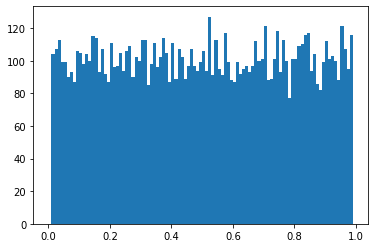

In [7]:
plt.hist([task.getData()['parameters']['connectivity'] for task in listOfTasks],bins=np.arange(100)/100);

The code below does the real work: the tasks are executed serially. After execution (whether successful or not), the output values are written to a CSV file. Executing this cell probably takes a really long time, it gives output after each task.

In [ ]:
VERBOSE = False
counter = 0;
with open(pklFile, "wb") as f:
    pkl.dump(listOfTasks, f);
for task in listOfTasks:
    task.runTask(rerun=False);
    task.writeToCSV(csvFileName)
    with open(pklFile, "wb") as f:
        pkl.dump(listOfTasks, f);
    clear_output(wait=True)
    counter += 1;
    print("Completed " + str(counter) + " of " + str(len(listOfTasks)))